# Caching Schemes Experimentation

## Experiment Hyperparameters

In [1]:
MIN_CACHE_SIZE = 6
MAX_CACHE_SIZE = 12
MAX_NODES = 120
MIN_NODES = 20
ITERS_PER_GRAPH = 30
ITERS_PER_SIZE = 30

## Experiment

### Methodology

1. We will use the following caching schemes:
    - LRU
    - LFU
    - Weighted LFU
    - PageRank
    - Weighted PageRank
    - InDegree
    - Weighted InDegree
2. Our methodology for generating a 'repos' with `n` files is as follows:
    - We will generate a random graph with `n` nodes
    - Each node will represent a file, whose size will be randomly generated
    - The larger the file, the more dependencies it likely has
    - We will generate a random number of dependencies for each file and it connect it to random files
3. We will generate a random *distribution* of queries based on the following method:
    - The more dependencies a file has, the more likely it is to be queried
    - The larger the file, the more likely it is to be queried

In [ ]:
import networkx as nx
import numpy as np
import random

def generate_error_pdf(graph: nx.DiGraph, error_model='linear'):
    # Step 1: Extract file sizes from graph node attributes
    file_sizes = nx.get_node_attributes(graph, 'size')
    max_file_size = max(file_sizes.values())
    out_degrees = graph.out_degree()
    max_out_degree = max([out_degrees[node] for node in graph.nodes()])
    complexity = nx.get_node_attributes(graph, 'complexity')

    # Step 2: Apply the error model to file sizes
    if error_model == 'linear':
        error_weights = {node: 0.2*complexity[node] + 0.2*size/max_file_size + 0.6*out_degrees[node]/max_out_degree for node, size in file_sizes.items()}
    elif error_model == 'random':
        error_weights = {node: complexity[node] for node in file_sizes.keys()}
    else:
        raise ValueError("Unsupported error model")

    # Step 3: Normalize weights to create a probability distribution
    total_weight = sum(error_weights.values())
    pdf = {node: weight / total_weight for node, weight in error_weights.items()}

    return pdf

In [3]:
from utils.cache import Cache
import networkx as nx
import random
from tqdm import tqdm
from collections import defaultdict
from utils.graphutils import random_code_graph
import time

num_subclasses = len(Cache.__subclasses__())

sized_caches = {size: [CacheType(size) for CacheType in Cache.__subclasses__()] for size in range(MIN_CACHE_SIZE, MAX_CACHE_SIZE+1)}
# caches[size][i] = cache of size `size` using the `i`th cache replacement policy

cache_hit_rate = {size: [defaultdict(int) for _ in range(num_subclasses)] for size in range(MIN_CACHE_SIZE, MAX_CACHE_SIZE+1)}
# cache_hit_rate[size][i][j] = avg hit rate for cache i, graph size j, cache size `size`

cache_timings = {size: [defaultdict(int) for _ in range(num_subclasses)] for size in range(MIN_CACHE_SIZE, MAX_CACHE_SIZE+1)}
# cache_timings[size][i][j] = avg time taken for cache i, graph size j, cache size `size`

for n in tqdm(range(MIN_NODES, MAX_NODES+1)):  # Loop over graph sizes
    local_hit_rates = {size: [[] for _ in range(num_subclasses)] for size in range(MIN_CACHE_SIZE, MAX_CACHE_SIZE+1)}
    # local_hit_rates[size][i] = hit rates for cache i of size `size`
    local_timings = {size: [[] for _ in range(num_subclasses)] for size in range(MIN_CACHE_SIZE, MAX_CACHE_SIZE+1)}
    # local_timings[size][i] = timings for cache i of size `size`
    for _ in range(ITERS_PER_SIZE):  # Generate random graphs for each size
        G = random_code_graph(n)
        pdf = generate_error_pdf(G)
        for size, caches in sized_caches.items():
            for cache in caches:
                cache.clear()
                cache.initialize(G)
        for _ in range(ITERS_PER_GRAPH):  # Randomly select nodes to test
            u = random.choices(list(G.nodes()), weights=[pdf[node] for node in G.nodes()])[0]
            bug_complexity = random.uniform(0, 1)
            # Get dependencies of `u`
            dependencies = set(G[u]) | {u}
            # Randomly generated the number of queries to make based on the size of the file and the complexity
            num_queries = int(np.log(max(1, (G.nodes[u]['size'] * G.nodes[u]['complexity'] * bug_complexity)/3)) + 1)
            # Query cache based on dependencies
            for _ in range(num_queries):
                for dep in dependencies:
                    for size, caches in sized_caches.items():
                        for i, cache in enumerate(caches):
                            startTime = time.time()
                            cache.query(dep)
                            endTime = time.time()
                            local_timings[size][i].append(endTime-startTime)
        for size, caches in sized_caches.items():
            for i, cache in enumerate(caches):
                local_hit_rates[size][i].append(cache.hit_rate())
                cache.reset()
    for size, caches in sized_caches.items():
        for i in range(num_subclasses):
            cache_hit_rate[size][i][n] = np.mean(local_hit_rates[size][i])
            cache_timings[size][i][n] = np.mean(local_timings[size][i])

100%|██████████| 101/101 [00:46<00:00,  2.17it/s]


In [4]:
import numpy as np

# convert cache_hit_rate to a numpy array
cache_hit_rate_np = np.zeros((MAX_CACHE_SIZE-MIN_CACHE_SIZE+1, num_subclasses, MAX_NODES-MIN_NODES+1))
for size in range(MIN_CACHE_SIZE, MAX_CACHE_SIZE+1):
    for i in range(num_subclasses):
        for n in range(MIN_NODES, MAX_NODES+1):
            cache_hit_rate_np[size-MIN_CACHE_SIZE, i, n-MIN_NODES] = cache_hit_rate[size][i][n]

np.save('hit_rate_array.npy', cache_hit_rate_np)

# convert cache_timings to a numpy array
cache_timings_np = np.zeros((MAX_CACHE_SIZE-MIN_CACHE_SIZE+1, num_subclasses, MAX_NODES-MIN_NODES+1))
for size in range(MIN_CACHE_SIZE, MAX_CACHE_SIZE+1):
    for i in range(num_subclasses):
        for n in range(MIN_NODES, MAX_NODES+1):
            cache_timings_np[size-MIN_CACHE_SIZE, i, n-MIN_NODES] = cache_timings[size][i][n]

np.save('timings_array.npy', cache_timings_np)

In [5]:
import numpy as np

hit_rate_array = np.load('hit_rate_array.npy')
timings_array = np.load('timings_array.npy')

## Results

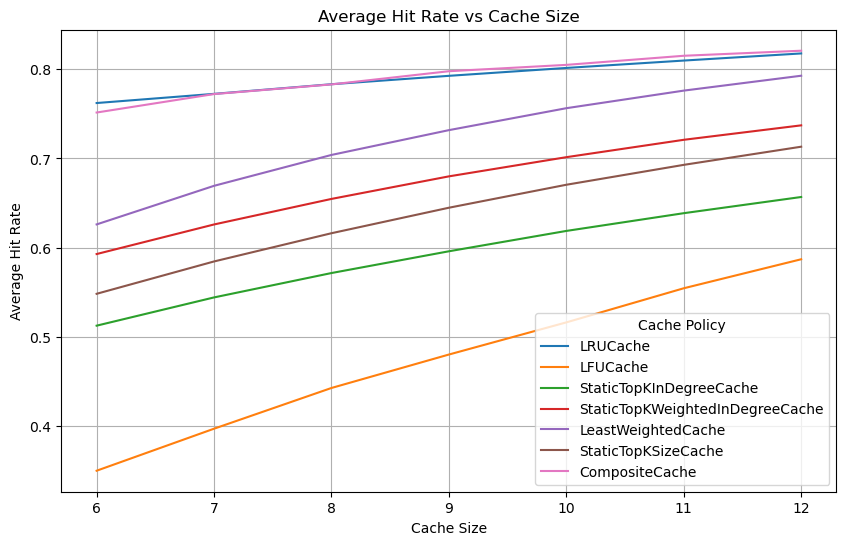

LRUCache: 0.00926891515259202
LFUCache: 0.039248159403670796
StaticTopKInDegreeCache: 0.023872429890757302
StaticTopKWeightedInDegreeCache: 0.023894980646787134
LeastWeightedCache: 0.027337574596781596
StaticTopKSizeCache: 0.027328242863976157
CompositeCache: 0.011265080700146084


In [6]:
from matplotlib import pyplot as plt

# Plot average hit rate vs cache size for all caches
plt.figure(figsize=(10, 6))

for i, cache in enumerate(Cache.__subclasses__()):
    avg_hit_rate_cache_size = hit_rate_array[:, i, :].mean(axis=1)  # Average over graph sizes
    plt.plot(range(MIN_CACHE_SIZE, MAX_CACHE_SIZE + 1), avg_hit_rate_cache_size, label=cache.__name__)

plt.title('Average Hit Rate vs Cache Size')
plt.xlabel('Cache Size')
plt.ylabel('Average Hit Rate')
plt.legend(title='Cache Policy')
plt.grid()
plt.show()

# Print the rate of change of hit rate with respect to cache size
for i, cache in enumerate(Cache.__subclasses__()):
    avg_hit_rate_cache_size = hit_rate_array[:, i, :].mean(axis=1)  # Average over graph sizes
    lsrl = np.polyfit(range(MIN_CACHE_SIZE, MAX_CACHE_SIZE + 1), avg_hit_rate_cache_size, 1)
    print(f'{cache.__name__}: {lsrl[0]}')

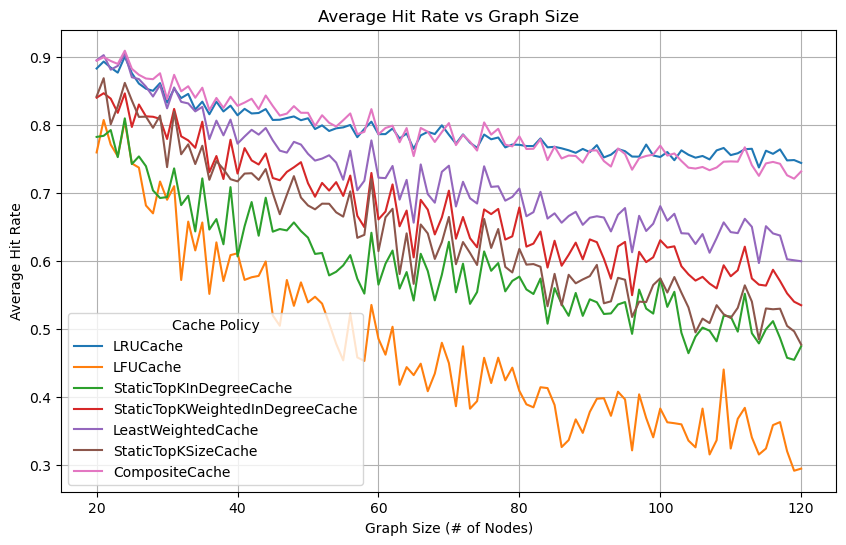

LRUCache: 0.7912124852034506
LFUCache: 0.4754095369708137
StaticTopKInDegreeCache: 0.5911890110432302
StaticTopKWeightedInDegreeCache: 0.6732040347179851
LeastWeightedCache: 0.7222294865098203
StaticTopKSizeCache: 0.6385671757095679
CompositeCache: 0.7920617011075637


In [13]:
import matplotlib.pyplot as plt

# Plot average hit rate vs graph size for all caches
plt.figure(figsize=(10, 6))

for i, cache in enumerate(Cache.__subclasses__()):
    avg_hit_rate_graph_size = hit_rate_array[:, i, :].mean(axis=0)  # Average over cache sizes
    plt.plot(range(MIN_NODES, MAX_NODES + 1), avg_hit_rate_graph_size, label=cache.__name__)

plt.title('Average Hit Rate vs Graph Size')
plt.xlabel('Graph Size (# of Nodes)')
plt.ylabel('Average Hit Rate')
plt.legend(title='Cache Policy')
plt.grid()
plt.show()

# Print the average hit rate for each cache policy
for i, cache in enumerate(Cache.__subclasses__()):
    avg_hit_rate_graph_size = hit_rate_array[:, i, :].mean(axis=0)  # Average over cache sizes
    print(f'{cache.__name__}: {avg_hit_rate_graph_size.mean()}')

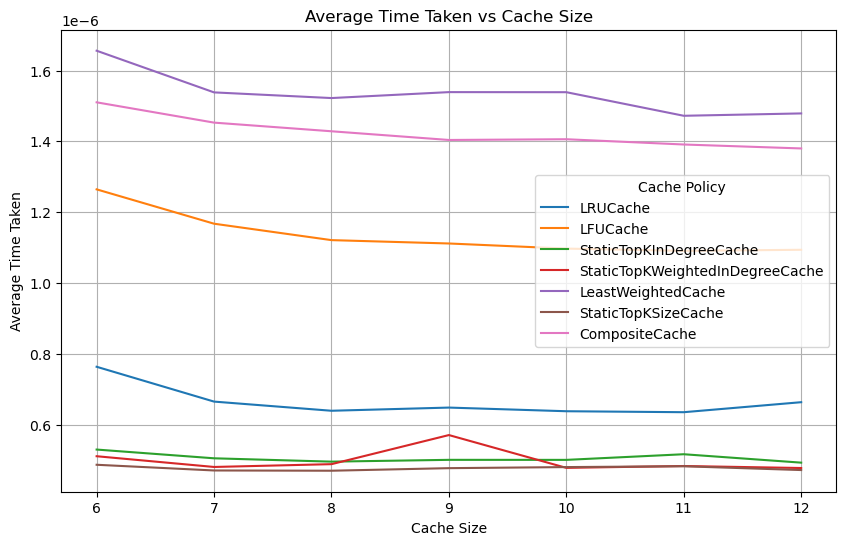

LRUCache: -1.2911282834536805e-08
LFUCache: -2.462619918283526e-08
StaticTopKInDegreeCache: -2.9627859639095257e-09
StaticTopKWeightedInDegreeCache: -3.7501098246704524e-09
LeastWeightedCache: -2.310721118214775e-08
StaticTopKSizeCache: -3.835094543817505e-10
CompositeCache: -1.9176933287752917e-08


In [8]:
from matplotlib import pyplot as plt

# Plot the average time taken vs cache size for all caches
plt.figure(figsize=(10, 6))
for i, cache in enumerate(Cache.__subclasses__()):
    avg_time_cache_size = timings_array[:, i, :].mean(axis=1)  # Average over graph sizes
    if cache.__name__ == 'CompoundCache': continue
    plt.plot(range(MIN_CACHE_SIZE, MAX_CACHE_SIZE + 1), avg_time_cache_size, label=cache.__name__)

plt.title('Average Time Taken vs Cache Size')
plt.xlabel('Cache Size')
plt.ylabel('Average Time Taken')
plt.legend(title='Cache Policy')
plt.grid()
plt.show()

# Print the rate of change of time taken with respect to cache size
for i, cache in enumerate(Cache.__subclasses__()):
    avg_time_cache_size = timings_array[:, i, :].mean(axis=1)  # Average over graph sizes
    lsrl = np.polyfit(range(MIN_CACHE_SIZE, MAX_CACHE_SIZE + 1), avg_time_cache_size, 1)
    print(f'{cache.__name__}: {lsrl[0]}')

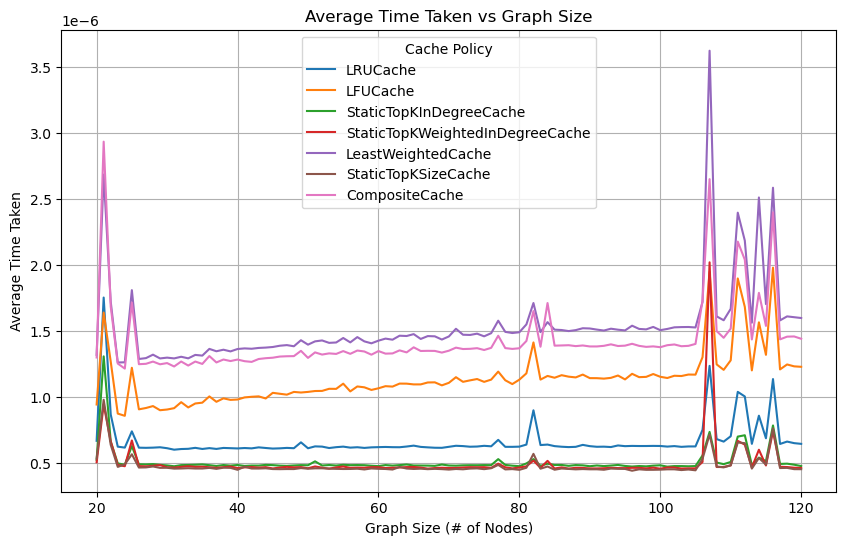

LRUCache: 6.64369495074814e-07
LFUCache: 1.1351325835921521e-06
StaticTopKInDegreeCache: 5.054474923683272e-07
StaticTopKWeightedInDegreeCache: 4.980991616309588e-07
LeastWeightedCache: 1.535196563014047e-06
StaticTopKSizeCache: 4.7662149556923437e-07
CompositeCache: 1.424738105838958e-06


In [9]:
import matplotlib.pyplot as plt

# Plot average time taken vs graph size for all caches
plt.figure(figsize=(10, 6))
for i, cache in enumerate(Cache.__subclasses__()):
    avg_time_graph_size = timings_array[:, i, :].mean(axis=0)  # Average over cache sizes
    plt.plot(range(MIN_NODES, MAX_NODES + 1), avg_time_graph_size, label=cache.__name__)

plt.title('Average Time Taken vs Graph Size')
plt.xlabel('Graph Size (# of Nodes)')
plt.ylabel('Average Time Taken')
plt.legend(title='Cache Policy')
plt.grid()
plt.show()

# Print the average time taken for each cache policy
for i, cache in enumerate(Cache.__subclasses__()):
    avg_time_graph_size = timings_array[:, i, :].mean(axis=0)  # Average over cache sizes
    print(f'{cache.__name__}: {avg_time_graph_size.mean()}')